## 0. 라이브러리 로드


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## 1. 데이터 불러오기 및 구조 확인


In [2]:
df = pd.read_csv("trip.csv")
df.head()


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount
0,Pamela Duffy,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,Debit Card,6,3.34,13.0,2.76,0.0
1,Michelle Foster,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,Debit Card,1,1.80,16.0,4.00,0.0
2,Tina Combs,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,Debit Card,1,1.00,6.5,1.45,0.0
3,Anthony Ray,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,Cash,1,3.70,20.5,6.39,0.0
4,Brianna Johnson,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,Debit Card,1,4.37,16.5,0.00,0.0


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22701 entries, 0 to 22700
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_name         22701 non-null  object 
 1   tpep_pickup_datetime   22701 non-null  object 
 2   tpep_dropoff_datetime  22701 non-null  object 
 3   payment_method         22701 non-null  object 
 4   passenger_count        22701 non-null  int64  
 5   trip_distance          22701 non-null  float64
 6   fare_amount            22698 non-null  float64
 7   tip_amount             22701 non-null  float64
 8   tolls_amount           22701 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.6+ MB


## 2. 결측치 확인 및 처리


In [4]:
(df.isnull().mean()*100).sort_values(ascending=False)


fare_amount              0.013215
passenger_name           0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
payment_method           0.000000
passenger_count          0.000000
trip_distance            0.000000
tip_amount               0.000000
tolls_amount             0.000000
dtype: float64

### 처리 전략
- `fare_amount` 결측치는 소수이므로 제거


In [5]:
df = df.dropna(subset=["fare_amount"])


## 3. 이상치 탐색


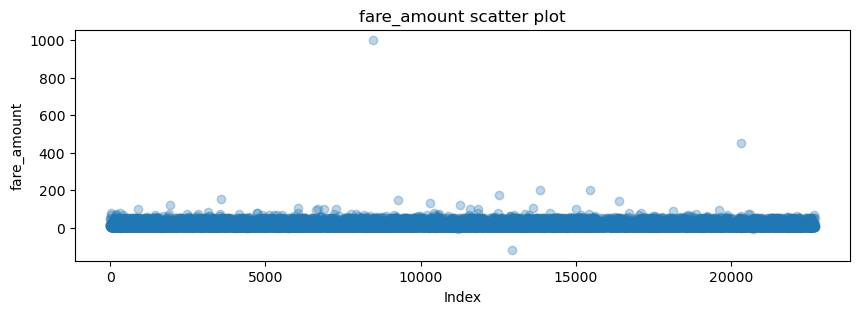

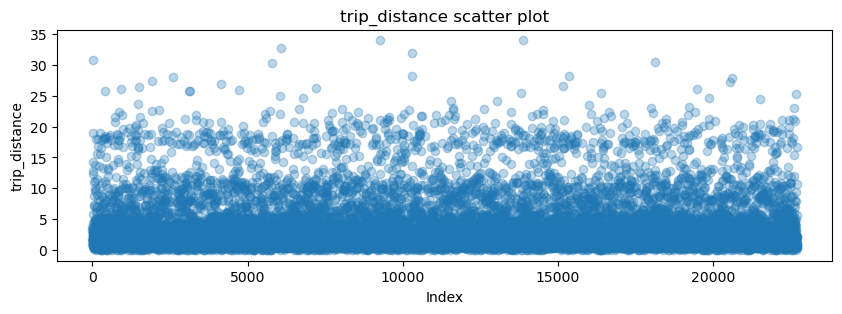

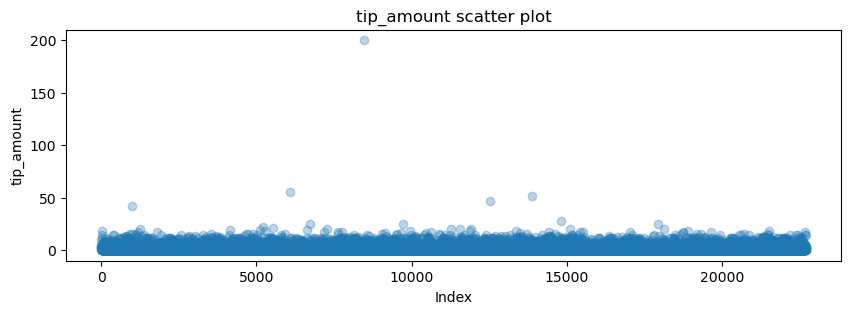

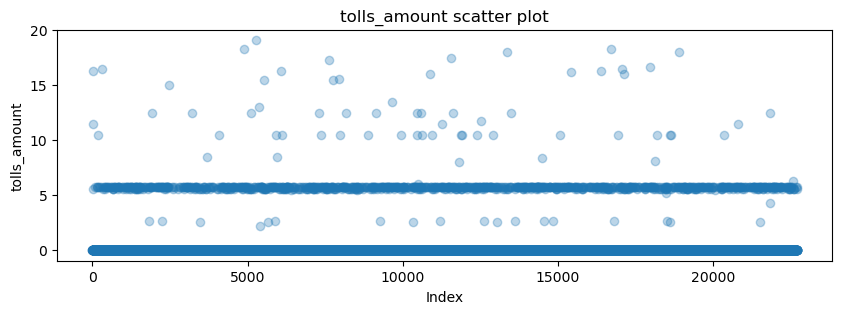

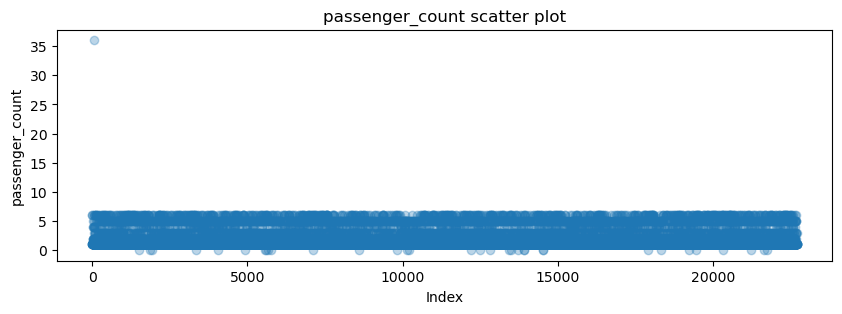

In [6]:
num_cols = ["fare_amount","trip_distance","tip_amount","tolls_amount","passenger_count"]

for col in num_cols:
    plt.figure(figsize=(10,3))
    plt.scatter(df.index, df[col], alpha=0.3)
    plt.title(f"{col} scatter plot")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.show()


## 4. 이상치 제거


In [7]:
df = df[
    (df["fare_amount"] > 0) & (df["fare_amount"] < 300) &
    (df["trip_distance"] > 0) & (df["trip_distance"] < 100) &
    (df["passenger_count"] >= 1)
].copy()

df.shape


(22501, 9)

## 5. 날짜/시간 데이터 변환 및 파생변수 생성


In [8]:
df["tpep_pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["tpep_dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

df["trip_duration"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60

df = df[df["trip_duration"] > 0]

df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_dayofweek"] = df["tpep_pickup_datetime"].dt.dayofweek

df.head()


,passenger_name,tpep_pickup_datetime,tpep_dropoff_datetime,payment_method,passenger_count,trip_distance,fare_amount,tip_amount,tolls_amount,trip_duration,pickup_hour,pickup_dayofweek
0,Pamela Duffy,2017-03-25 08:55:43,2017-03-25 09:09:47,Debit Card,6,3.34,13.0,2.76,0.0,14.066667,8,5
1,Michelle Foster,2017-04-11 14:53:28,2017-04-11 15:19:58,Debit Card,1,1.80,16.0,4.00,0.0,26.500000,14,1
2,Tina Combs,2017-12-15 07:26:56,2017-12-15 07:34:08,Debit Card,1,1.00,6.5,1.45,0.0,7.200000,7,4
3,Anthony Ray,2017-05-07 13:17:59,2017-05-07 13:48:14,Cash,1,3.70,20.5,6.39,0.0,30.250000,13,6
4,Brianna Johnson,2017-04-15 23:32:20,2017-04-15 23:49:03,Debit Card,1,4.37,16.5,0.00,0.0,16.716667,23,5


## 6. 결제 수단 통합


In [9]:
df["payment_method"] = df["payment_method"].replace({
    "Credit Card": "Card",
    "Debit Card": "Card"
})

df["payment_method"].value_counts()


payment_method
Card    11404
Cash    11096
Name: count, dtype: int64

## 7. 요금과 주요 변수 관계 확인


In [10]:
df[["fare_amount","trip_distance","trip_duration"]].corr()


,fare_amount,trip_distance,trip_duration
fare_amount,1.000000,0.936046,0.174155
trip_distance,0.936046,1.000000,0.154683
trip_duration,0.174155,0.154683,1.000000


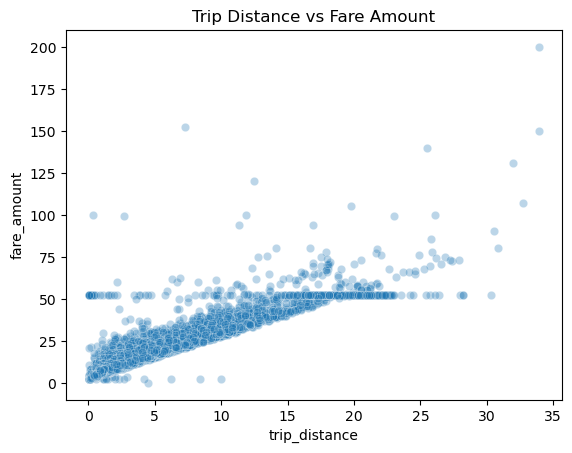

In [11]:
sns.scatterplot(data=df, x="trip_distance", y="fare_amount", alpha=0.3)
plt.title("Trip Distance vs Fare Amount")
plt.show()


## 8. 최종 데이터 저장


In [12]:
df.to_csv("trip_clean.csv", index=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 22500 entries, 0 to 22700
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   passenger_name         22500 non-null  object        
 1   tpep_pickup_datetime   22500 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  22500 non-null  datetime64[ns]
 3   payment_method         22500 non-null  object        
 4   passenger_count        22500 non-null  int64         
 5   trip_distance          22500 non-null  float64       
 6   fare_amount            22500 non-null  float64       
 7   tip_amount             22500 non-null  float64       
 8   tolls_amount           22500 non-null  float64       
 9   trip_duration          22500 non-null  float64       
 10  pickup_hour            22500 non-null  int32         
 11  pickup_dayofweek       22500 non-null  int32         
dtypes: datetime64[ns](2), float64(5), int32(2), int64(1), object(2)
m